# Cepstral space strain mapping - example notebook

## Table of Contents <a name="toc"/>
[1. Introduction](#intro)<br>
[2. Import packages and data](#load)<br>
[3. Browse 4D STEM data](#browse)<br> 
[4. Exit Wave Power Cepstrum (EWPC)](#EWPC)<br> 
[5. Spot maps](#bspot) - Map of length and angle of the EWPC spots with respect to the center.<br>
[6. Strain maps](#bstrain) - Map of the strain matrix components.<br>
[7. PCA Decomposition and Clustering](#PCA) - Segment the region of interest.<br>


## 1. Introduction <a name="intro"/>

This is an example notebook to introduce strain mapping using the Exit Wave Power Cepstral (EWPC) transform method developed at Cornell - [Padgett et al., Ultramicroscopy 214, 112994 (2019)](https://doi.org/10.1016/j.ultramic.2020.112994). 

Dataset - The sample is a lead titanate (PTO) thin film grown on dysprosium scandate (DSO) substrate. The lattice mismatch prompts the PTO film to form c/a domain structure to minimize the strain energy. Further details about the sample and domain structure can be found at [Langenberg et al., Nano Lett. 2019, 19, 11, 7901–7907](https://doi.org/10.1021/acs.nanolett.9b02991).


This notebook is color-coded. When your input is needed, the markdown cell will indicate the part with <span style="color:orange">this orange color</span>.

[go to top](#toc)
## 2. Import packages and functions <a name="load"/>

In [1]:
#Custom functions used in this script, which are stored in fun.py
from fun import * #* means import all functions within the script

%matplotlib widget

## Load 4D-STEM Data (.raw format)
<span style="color:orange">Enter the directory where the 4D-STEM raw file is located </span> to assign the variable ***`inputDir`*** <span style="color:orange">and the file name </span> as ***`fname`***. <br>

Enter data dimensions and whether there are transformations like flips/transposes between real space scan and diffraction space coordinates.

In [2]:
inputDir='./' #directory where the 4D STEM data file is.
fname= 'PTODSO_small_128x130x64x64_float_x64_y64.raw' #name of the 4D-STEM data
saveDir = './'#./ means current directory; where this Jupyter notebook is.spotmaps file will be saved here.

# Scan size
Nx1 = 64
Nx2 = 64

# Size of each frame
Nk1 = 130
Nk2 = 128

# Data transformations
flipx = False
flipy = False
transpose = True

# For EMPAD 1 datasets, the metadata is saved as part of the raw file and needs to be removed
EMPAD1 = True

# Load data
data4d=load_raw_to_dp(inputDir+fname, Nx1, Nx2, Nk1, Nk2, flipx, flipy, transpose, EMPAD1)

If your 4D-STEM data is not a raw file, read the file in as you normally would, and convert the data to a numpy array with the name 'data4d'

### Check the dimensions

In [3]:
(rx,ry,sx,sy)=data4d.shape #order: N_x1,N_x2,N_k1,N_k2
(rx,ry,sx,sy)

(64, 64, 124, 124)

[go to top](#toc)
## 3. Browse the 4D-STEM Data <a name="browse"/>
### 3a) Interactive version<a name="3a"/>

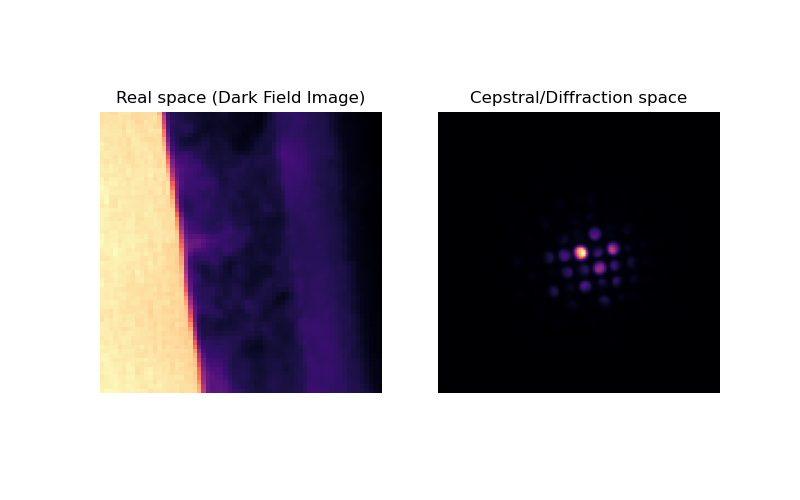

In [4]:
plt.close('all')
guis=browser(data4d, cmap='magma')

<span style="color:orange">On the real space image (image on the left), click and drag over the region of interest</span>. Then, the average diffraction pattern (DP) from the region inside the shaded red box will be shown on the right. 

<span style="color:orange"> Drawing a box in diffraction space </span> will show the image corresponding to the virtual detector defind by the selected area in diffraction space. <br>

### b) Static viewer

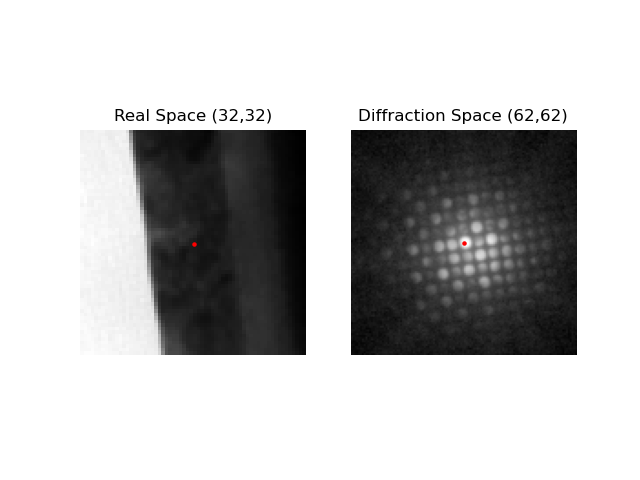

In [5]:
# Real space probe position
x1 = 32
x2 = 32

# Diffraction space point detector
k1 = 62
k2 = 62

statDisp(data4d,[x1,x2],[k1,k2]);

### c) Virtual ADF image <a name="3b"/>
Specify the radii (`r0` & `r1`) for the virtual ADF mask. The virtual ADF image generated during this process will be used for selecting the region of interest for the EWPC strain mapping.<br>

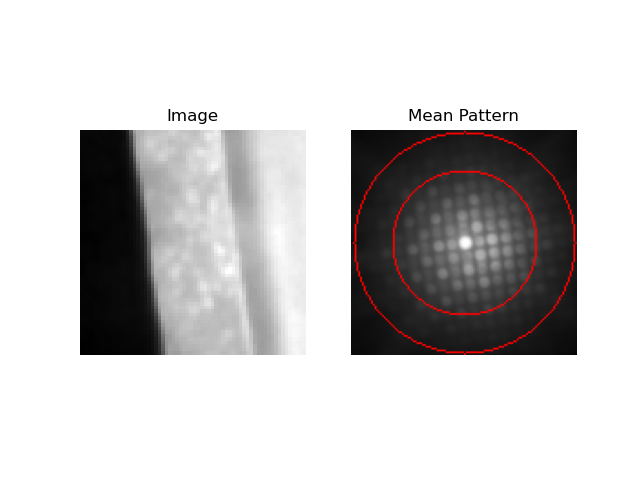

In [6]:
r0=40 #inner radius
r1=60 #outer radius
disp_haadf(data4d,[r0,r1])

[go to top](#toc)
## 4. EWPC<a name="EWPC"/>
### 4a) Perform cepstral transform <a name="ct"/>
Theory of cepstral transforms for strain mapping: [Padgett et al., Ultramicroscopy 214, 112994 (2019)](https://doi.org/10.1016/j.ultramic.2020.112994). 

In [7]:
ewpc=convert_dp_to_ewpc(data4d)

100%|██████████████████████████████████████████| 64/64 [00:04<00:00, 12.96it/s]


### 4b) Select EWPC peaks for strain map <a name="peak"/>
Just like you did with the 4D browser,<br>
<span style="color:orange">1)</span> Draw a rectangle in the leftmost window to indicate the area of interest. This will be the real space region over which strain mapping will be performed.

<span style="color:orange">2)</span> Draw another box around a peak in the cepstral space. Make sure the peak is close to the center of the rectangle.

<span style="color:orange">3)</span> The rightmost window will show a zoomed in image of the box drawn in the middle window. Select just the peak (the brightest spot within the diffraction disk) area, by drawing another box. <b> This step is mandatory </b> and the cepstral region selected here is used for peak-finding.

<span style="color:orange">4)</span> Click on `Save Results` button to add the region of interest and window location for the strain analysis.

<span style="color:orange">5)</span> Repeat steps 2-4 at least once (you need at least two vectors to calculate strain)

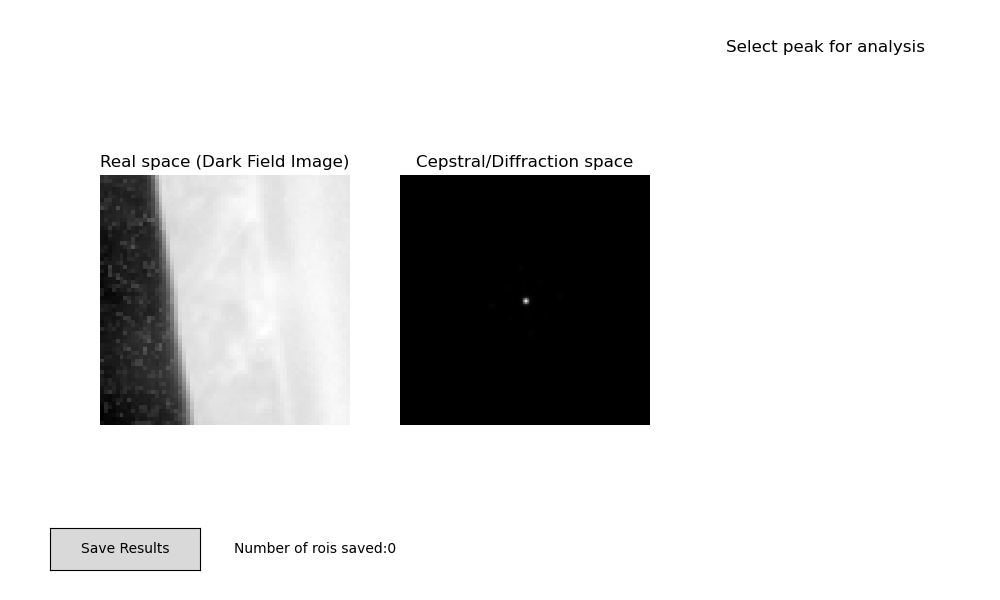

In [8]:
guis,wins,rois=browser_with_peak_selection(ewpc)

The EWPC pattern picks out the periodicity in the diffraction patterns. The different peaks in cepstral space corresponds to different projected interatomic distances in the crystal. So, by tracking the changes in the peak positions of the EWPC spots, we can map out the strain!

# Confirm selection on the dark field cepstral STEM image
Check the region you selected.

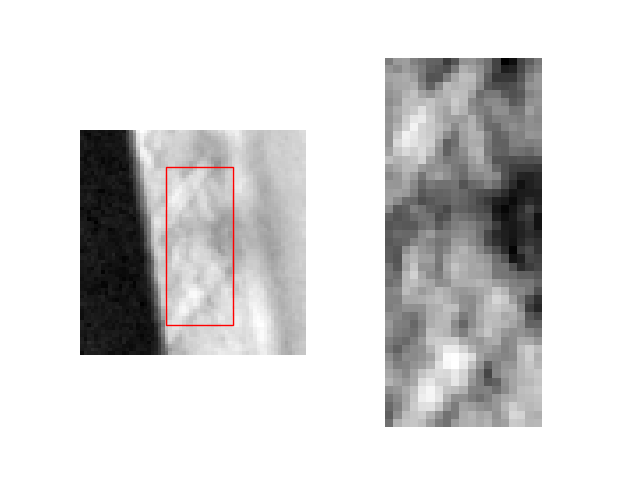

In [9]:
plt.close('all')
roi=rois[0] 

#roi=[ 7, 54,  0, 63] #wins=[[56, 64, 42, 49],[75, 82, 56, 63]] #Can also enter the roi and cepstral window coordinates manually


wins=np.array(wins)
show_roi(ewpc,roi,wins) 

Make sure the selected peaks are shown below within the red boxes.

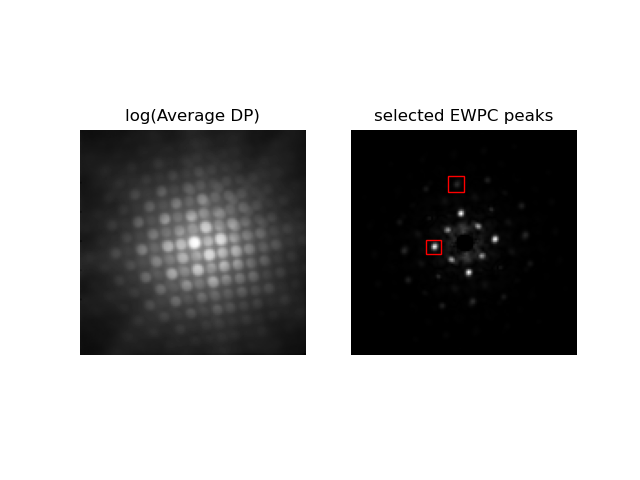

In [10]:
data4d_roi,ewpc_img=show_wins(data4d,wins,roi)

### 4c) Calculate spot maps <a name="spotmap"/>

Calculate the peak position of the above selected EWPC spots with sub-pixel precision. After the peak position is found, the length and angle of the peak from the center is found.


Tolerance sets the precision of the optimization program. <br>
Available peak finding ***`method`*** from fastest to slowest : ***`L-BFGS-B`***, ***`Powell`***,***`Nelder-Mead`*** (default),***`TNC`***

In [11]:
spotMaps_upd = get_spotMaps(data4d_roi,wins,tol=1e-4,method='L-BFGS-B')

100%|████████████████████████████████████████| 855/855 [00:11<00:00, 74.16it/s]

Time spent: 12s


Save ***`spotMaps`***

In [12]:
spotMaps_upd['wins']=np.array(wins)
spotMaps_upd['roi']=rois[0]
pickle.dump(spotMaps_upd,open(saveDir+'/spotMaps.dat','wb'))

[go to top](#toc)
## 5. Spot Maps <a name="bspot"/>

Plot of the vector length and angle for the peak positions of the selected EWPC spots. The vector length is in units of pixels and vector angle in units of degrees.

In [13]:
#spotMaps_upd=pickle.load(open(saveDir+'/spotMaps.dat','rb'))  # upload previously saved spot maps
wins=np.array(spotMaps_upd['wins'])
roi=spotMaps_upd['roi']

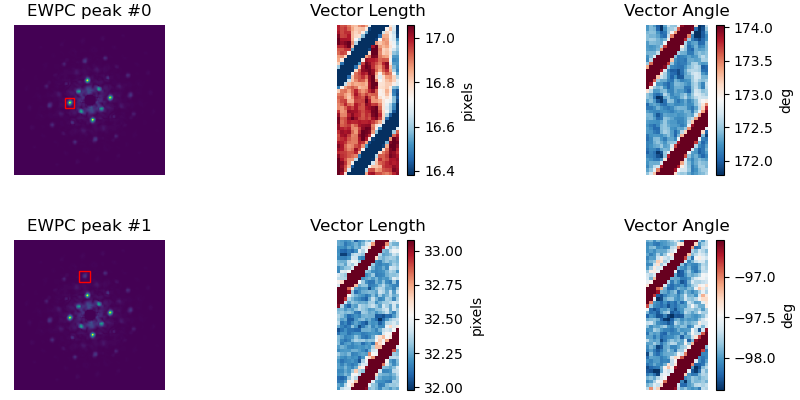

In [14]:
plotSpotMaps(wins,ewpc_img,spotMaps_upd,figureSize=(8,4) )

PTO has a tetragonal unit cell with its long axis in the direction of ferroelectric polarization. The lattice mismatch with the DSO substrate causes the PTO film to form c/a domains to accomodate the epitaxial strain.

[go to top](#toc)
## 6. EWPC strain map <a name="bstrain"/>

***`plot_ids`***: <span style="color:orange">Select indices of EWPC peaks</span> from which you would like to get the maps. If you selected only two, enter `[1,2]`<br>

In [15]:
peak_ids=[1,2]
new_spotMaps=trim_spotMaps(spotMaps_upd,peak_ids)

In [21]:
spotRef = makeRelativeSpotReference_median( new_spotMaps, [0,64,0,64]) #uses the average position of the EWPC spots in the ROI as reference for strain mapping

image_basis = 0 # If set to 0, uses chosen EWPC spots as basis vectors for strain matrix, set to 1 if you want the image
#coordinates (i.e. the horizontal and vertical directions) as basis vectors; the latter is useful if the best choice of spots
#for peak finding are non-orthogonal

decomp_order = 1 # choice of left(0)/right(1) polar decomposition of deformation matrix into strain and rotation matrices.
#Use 1 if you want reference EWPC positions as basis vectors
#Use 0 if you want measured EWPC peaks at current pixel position as basis vectors

strainComponents = calculateStrainMap(new_spotMaps, spotRef, latticeCoords=decomp_order, image_basis=image_basis )

The distortion/deformation matrix relating the position of the EWPC peak position at each pixel to the reference position is calculated, and decoupled into in-plane rotation and lattice parameter change (strain tensor).


The strain tensor components describes the lattice expansion/contraction : $\epsilon_{11}$, $\epsilon_{22}$ and diagonal $\epsilon_{12}$ stretches. $\theta$ is the angle of in-plane lattice rotation. 

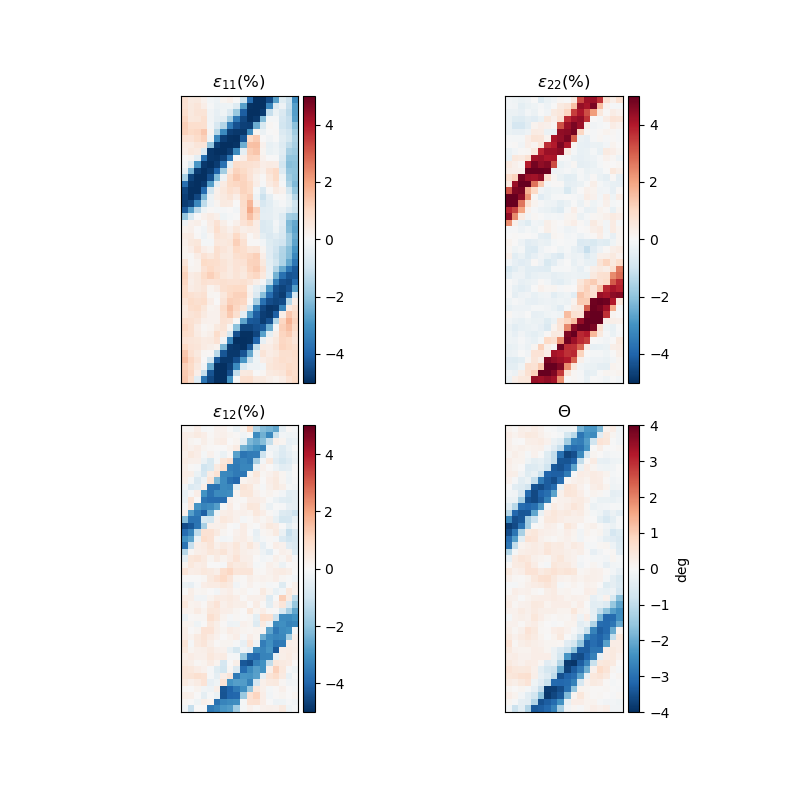

In [22]:
plotStrainTensor(strainComponents,figureSize=(8,8), vrange_eps=[-5,5], vrange_theta = [-4,4])

Save ***`strainComponents`***

In [23]:
pickle.dump(strainComponents,open(saveDir+'/strainComponents.dat','wb'))

[go to top](#toc)

##  Some Tips <a name="cp4"/>
In general, the EWPC spots must be robust over the entire ROI, and should have a good SNR. Noisy spots $\implies$ Noisy strain maps.

Also make sure, the window around the EWPC spot is such that it is: i) big enough to captures any shifts due to changes in lattice spacing ii) small enough that there is no interference from other nearby EWPC spots.


# 7.PCA Decomposition and Clustering <a name="PCA"/>

In many datasets like the above, it is desirable to do a segmentation to select only a portion of the scan area for strain analysis. Here, we use PCA decomposition of the cepstral data and k-means clustering to segment out the sample area from the vacuum region.

In [24]:
n_components=20 # number of components for PCA decomposition
radii=[5,64] # inner and outer radius of the mask in cepstral space for PCA decomposition

center_beam_mask=create_haadf_mask((ewpc.shape[2],ewpc.shape[3]),radii)
pca,scores=pca_decomposition(ewpc,n_components,center_beam_mask)

flattenning the cepstral signal


100%|███████████████████████████████████| 4096/4096 [00:00<00:00, 15860.64it/s]


normalization of the ewpc pattern


100%|██████████████████████████████████| 12626/12626 [00:01<00:00, 9274.55it/s]


In [25]:
## save pca model and scores
pickle.dump(pca, open(saveDir+'pca.pkl','wb'))
np.save(saveDir+'/scores.npy',scores)

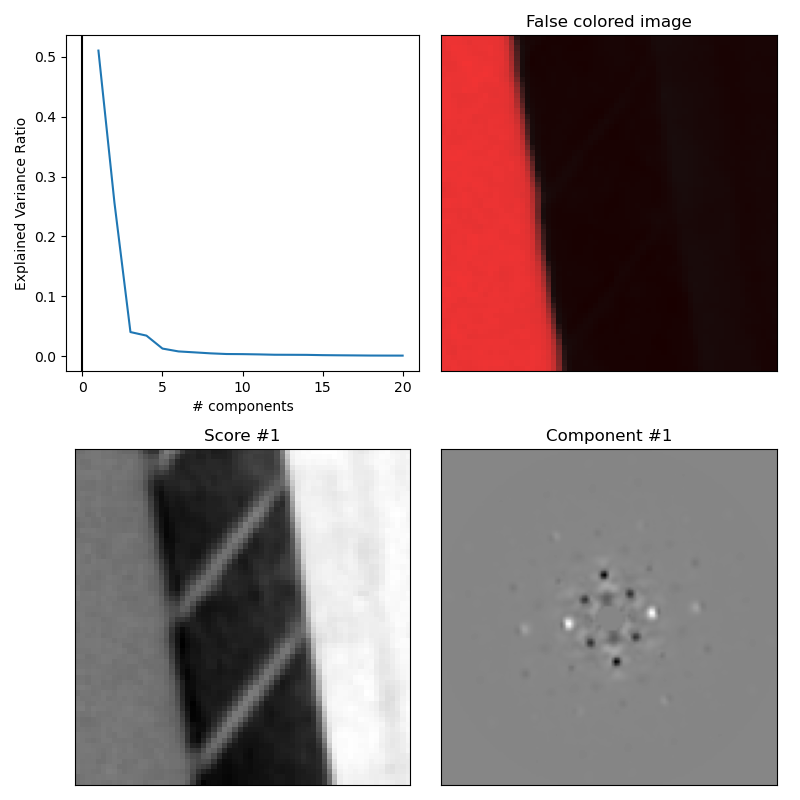

In [26]:
plot_false_color_img(pca,scores,center_beam_mask,cmap='gray')

### The different PCA components and a false colored image of their cumulative sum can be visualized by moving the slider to set the cutoff value for the number of PCA components.

### One can already see the effectiveness of the PCA decomposition to separate out different features like the vacuum region, substrate and domain patterns in the film.

In [27]:
clusters_range=[2,5] # minimum and maximum nuber of clusters to segment the data into
cut_off=5 # number of PCA components to be used for clustering

kmeans_dict=perform_kmeans(scores,cut_off,clusters_range)

Performing clustering


  0%|                                                    | 0/3 [00:00<?, ?it/s]C:\Users\harik\anaconda3\envs\cepstral\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 33%|██████████████▋                             | 1/3 [00:00<00:00,  3.22it/s]C:\Users\harik\anaconda3\envs\cepstral\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
 67%|█████████████████████████████▎              | 2/3 [00:00<00:00,  3.59it/s]C:\Users\harik\anaconda3\envs\cepstral\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|████████

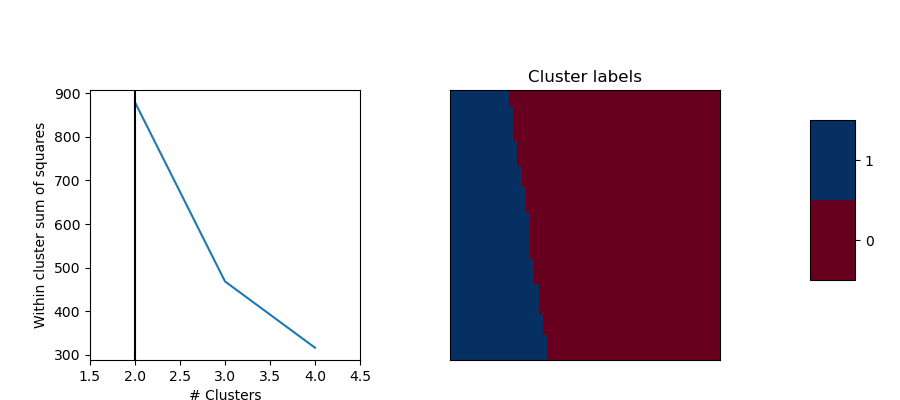

In [28]:
plot_kmeans_dict(kmeans_dict)

In [30]:
### choose the number of clusters and select the index of the region of interest

num_clusters = 2
cluster_label = 0

mask=kmeans_dict[num_clusters]['label']==cluster_label

### Once we have the mask segmenting out the region of interest, we can track the peak positions of the EWPC spots and produce clean strain maps only for the chosen region.

In [31]:
spotMaps=get_spotMaps(data4d,wins,valid=mask,tol=1e-4) 

100%|██████████████████████████████████████| 2907/2907 [01:57<00:00, 24.80it/s]

Time spent: 117s


In [32]:
spotMaps['wins']=np.array(wins)
spotMaps['roi']=rois[0]
pickle.dump(spotMaps,open(saveDir+'/segmented_spotMaps.dat','wb'))

wins=np.array(spotMaps['wins'])
roi=spotMaps['roi']

C:\Users\harik\AppData\Local\Temp\ipykernel_18156\104510041.py:1: RuntimeWarning: divide by zero encountered in log
  plotSpotMaps(wins,np.log(ewpc_img),spotMaps,figureSize=(8,4))


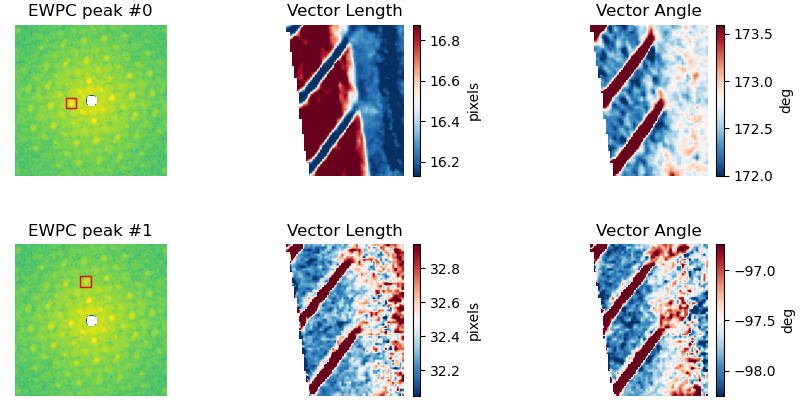

In [33]:
plotSpotMaps(wins,np.log(ewpc_img),spotMaps,figureSize=(8,4))

In [35]:
peak_ids=[1,2]
new_spotMaps=trim_spotMaps(spotMaps,peak_ids)

spotRef = makeRelativeSpotReference( new_spotMaps, [0,rx-1,0,ry-1]) #uses the average position of the EWPC spots in the ROI as reference for strain mapping
strainComponents = calculateStrainMap(new_spotMaps, spotRef, latticeCoords=decomp_order, image_basis=image_basis )

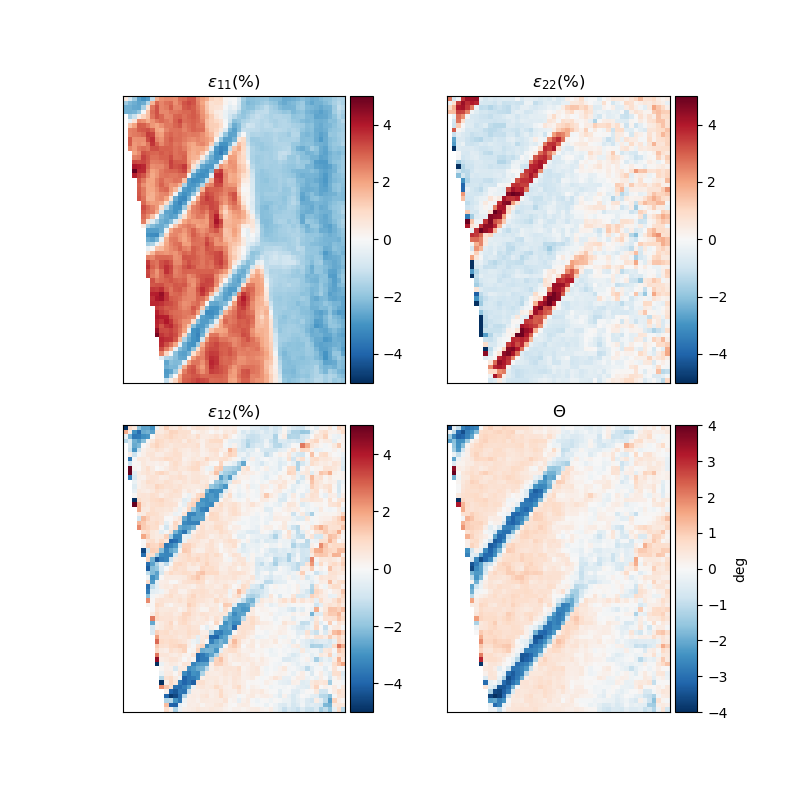

In [36]:
plotStrainTensor(strainComponents,figureSize=(8,8), vrange_eps = [-5,5], vrange_theta = [-4,4])

[go to top](#toc)

### <span style="color:darkturquoise"> You may change the functions within fun.py. If you do so, you can import the updated functions by running the following cell without restarting the kernel. </span>

In [27]:
import sys, importlib
importlib.reload(sys.modules['fun'])
from fun import *